## Demo 3: Custom analysis with raster data -- Calculating the steepest downhill neighbor slope using RasterCellIterator

- Slope in ArcGIS
- A custom slope algorithm based on steepest downhill neighbor
- Using Raster Cell Iterator (RCI) to calculate the custom slope 
- Deploy the custom slope method as a script tool in ArcGIS Pro

<img src='https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/GUID-43BD458B-05F2-4DC9-B133-12AE9C297797-web.png'>

source: https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/how-slope-works.htm

### Slope algorithm used in ArcGIS

![image.png](https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/GUID-B594EF46-3ECF-4FCF-82C4-1D3673135B67-web.gif)

\begin{equation*}
slopePercent   = \arctan(\sqrt{(\frac{dz}{dx})^2 + (\frac{dz}{dy})^2})
\end{equation*}

where $\frac{dz}{dx}$ is the rate of change in the horizontal direction for cell e, and $\frac{dz}{dy}$ is the rate of change in the vertical direction for cell e

\begin{equation*}
\frac{dz}{dx}  = \frac{\frac{(c + 2f + i) \times 4}{wght1} - \frac{(a + 2d + g) \times 4}{wght2}}{8 \times cellsize}
\end{equation*}

\begin{equation*}
\frac{dz}{dy}  = \frac{\frac{(g + 2h + i) \times 4}{wght3} - \frac{(a + 2b + c) \times 4}{wght4}}{8 \times cellsize}
\end{equation*}

where _wght1_ and _wght2_ are the horizontal weighted counts of valid cells and _wght3_ and _wght4_ are the vertical weighted counts of valid cells.

For instance, if:

- c, f, and i all have valid values, _wght1_ = (1+2*1+1) = 4.

- i is NoData, _wght1_ = (1+2*1+0) = 3.

- f is NoData, _wght1_ = (1+2*0+1) = 2.

### A custom slope algorithm based on steepest downhill neighbor

![image.png](steepest_downhill_slope.png)

**Algorithm:** It picks the steepest of the eight adjacent points slope value,  with the constrains that the point must be lower in elevation than the central point.  The slope value is assigned to the central point.
 
**Usage:**  Most drainage basin algorithms use a variant of this algorithm, looking only for the neighbor into which water will flow. 

**Reference** Jones, K.H., 1998, A comparison of algorithms used to compute hill slope as a property of the DEM: Computers & Geosciences, vol.24, no.4, p.315-324.

### Using Raster Cell Iterator (RCI) to calculate the custom slope 

In [50]:
import math
import arcpy
from arcpy.sa import Raster, RasterCellIterator

arcpy.env.overwriteOutput = True

print('Read input DEM...')
dem = Raster(r'C:\DevSummit20\PythonRaster\Data\SteepestDownhillSlope\Input\dem')
cell_x = dem.meanCellWidth
cell_y = dem.meanCellHeight
raster_info = dem.getRasterInfo()

# Set the output pixel type to be float 32
raster_info.setPixelType('F32')
new_slope = Raster(raster_info)

print('Start calculating steepest downhill neighbor slope...')
with RasterCellIterator({'rasters':[dem, new_slope]}) as rci:
    for r,c in rci:
        slopes = []
        
        # Iterate through 8 neighbors
        for x,y in [(-1,-1),(-1,0),(1,0),(0,-1),(0,1),(1,1),(-1,1),(1,-1)]:
            # Calculate the slope from center cell to each neighbor
            if dem[r,c] >= dem[r+x,c+y]: # only look for downhill slope
                slope = abs(dem[r,c]-dem[r+x,c+y]) / math.sqrt((x*cell_x)**2+(y*cell_y)**2)
                slopes.append(slope)
        
        # Assign the steepest slope to the output cell value
        if len(slopes) != 0:
            new_slope[r,c] = max(slopes)
        
print('Calculation finished.')
new_slope.save(r'C:\DevSummit20\PythonRaster\Data\SteepestDownhillSlope\Output\new_slope')
print('Output has been saved.')


Read input DEM...
Start calculating steepest downhill neighbor slope...
Calculation finished.
Output has been saved.


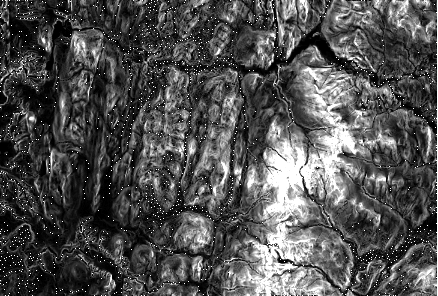

In [51]:
new_slope